In [1]:
#!pip install --upgrade tf_slim

import gym
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tf_slim as slim
import numpy.random as rnd
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
from collections import deque # container em forma de lista, com rapida insercao e remocao nas duas extremidades 
from ns3gym import ns3env

#from sklearn.preprocessing import label_binarize
#from keras.layers import Dense, Flatten, Reshape

/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sheila/

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_random_seed(seed)#tf.random.set_seed(seed)
random.seed(seed)

In [3]:
env = gym.make('ns3-v0') # environment ID 

ob_space = env.observation_space
ac_space = env.action_space
print("Observation space: ", ob_space,  ob_space.dtype)
print("Action space: ", ac_space, ac_space.dtype)

# numero de estados
state_size = ob_space.shape[0]

# numero de acoes
action_size = ac_space.shape[0]

print("\n")
print("Numero de Estados: ", state_size)
print("Numero de Acoes: ", action_size) 

Got new port for ns3gm interface:  5913
Observation space:  Box(0, 100, (5,), uint64) uint64
Action space:  Box(0, 100, (5,), uint64) uint64


Numero de Estados:  5
Numero de Acoes:  5


In [4]:
numExecutions = 100

numOfEpisodes = 100 #300 #200
#numTimeSlots = 1000 #600 #495

discount_rate = 0.9999 # 0.75 gamma 0.618; 0.528; 0.95---- 70 e decay = 0.9999 graph points meet
learning_rate = 0.75 # Learning rate 0.7


rewards = []
iterations = []

# Epsilon greedy parameters
epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1 # You can't explore more than 100% of the time
min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
decay = 0.0999999999 #0.01
epsilon_vec = np.zeros((numOfEpisodes,))

maxNofCollisions = 3

batch_size = 512 #1024 #256 #128 # tamanho do batch 128

MIN_REPLAY_SIZE = 3000 # tamanho minimo da memoria de repeticao

inputQueues = 5
cwSize = 100

In [5]:
def createModel(inputQueues, cwSize, loss='mse'):
    learning_rate = 0.65 #0.678 #0.01 #0.678 #
    init = tf.keras.initializers.he_uniform()#tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    # Input layer - número dos estados de entrada 
    model.add(keras.layers.Dense(inputQueues, input_shape=(inputQueues,), activation='relu', kernel_initializer=init))
    # Output layer - número de ações no ambiente
    model.add(keras.layers.Dense(cwSize, activation='linear', kernel_initializer=init))
    #model.add(keras.layers.Flatten())
    
    if(loss=='huber'):
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.Huber(), metrics=['accuracy'])
        print('Using Huber loss...', "\n")
    elif(loss=='mse'):
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])
        print('Using MSE loss...', "\n")
    else:
        print('Loss not defined...', "\n")
    return model

def train(replay_memory, model, model_target, done, batch_size, acc_history=[], loss_history=[]):
    mini_batch = random.sample(replay_memory, batch_size)
    c_states = np.array([transition[0] for transition in mini_batch])    
    #print("CSTATES", c_states, c_states.shape)
    current_qs_list  = model.predict(c_states)
    n_states = np.array([transition[3] for transition in mini_batch]) 
    future_qs_list = model_target.predict(n_states)
    
    
    X = []
    Y = []
    for index, (c_state, actionVec, reward, n_state, done) in enumerate(mini_batch):
        
        if not done:
            max_future_q = reward + discount_rate * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        
        current_qs = current_qs_list[index]
        #print("heyyyy")
        #action != 100
        for action in actionVec:
            if(action != 100):
                current_qs[action] = max_future_q

        X.append(c_state)
        Y.append(current_qs)

    # Train model with a mini-batch.
    history = model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

    # Store metrics.
    acc_history.append(history.history['acc'][0])
    loss_history.append(history.history['loss'][0])

    return history

In [6]:
print("Prediction Network")
# The first model makes the predictions for Q-values which are used to make a action.
model = createModel(inputQueues, cwSize)

print("Target Network")
# Build a target model for the prediction of future rewards.
model_target = createModel(inputQueues, cwSize)
# Initialize target model's weights.
model_target.set_weights(model.get_weights())

Prediction Network
Using MSE loss... 

Target Network
Using MSE loss... 



In [7]:
model.metrics_names

['loss', 'acc']

In [8]:
# numExecutions
for Execution in range(numExecutions):
#while n < numExecutions:
          
    
    acc_history = []
    loss_history = []

    episode_reward = np.zeros((numOfEpisodes,))
    max_reward =  np.zeros((numOfEpisodes,))
    replay_memory = deque(maxlen=50_000)

    steps_to_update_target_model = 0
    
    print("Execution Num:", Execution)
    print("----------------------------", "\n")
    
    
    for episode in range(numOfEpisodes):

        #print('Episode:', episode)

        state = env.reset()
        state = np.reshape(state, [1, state_size])
        #state = np.array(state)

        done = False
        total_reward = 0


        i = 0
        # Run episode
        while True:

            if done:
                break

            i += 1

            steps_to_update_target_model += 1

            #print("Time Slot   :", iteration)
            #print("----------------------")

            #print("Estado atual:", state[0])

            # Escolha da ação.
            if np.random.uniform() >= epsilon:

                #predicted = model.predict(state.reshape(1,4))
                #action = np.argmax(predicted[0])

                act = model.predict(state)
                act = act.reshape(20,5)

                action0 = np.argmax(act[:,0])            
                action1 = np.argmax(act[:,1])
                action2 = np.argmax(act[:,2])
                action3 = np.argmax(act[:,3])
                action4 = np.argmax(act[:,4])

                    #print("Action (Q)")
            else:

                action0 = np.random.randint(cwSize)
                action1 = np.random.randint(cwSize)
                action2 = np.random.randint(cwSize)
                action3 = np.random.randint(cwSize)
                action4 = np.random.randint(cwSize)
                #print("Action (rnd)")


            actionVec = [action0, action1, action2, action3, action4]
            #print("ActionVec   :", actionVec)

            next_state, reward, done, _, _ = env.step(actionVec)



            next_state = np.reshape(next_state, [1, state_size])
            #next_state = np.array(next_state)
            #print("Next State  :", next_state[0])

            #print("Reward      : ", reward)

            # Add information to replay buffer.
            replay_memory.append([state[0], actionVec, reward, next_state[0], done])          

            # Accumulate reward.
            total_reward += reward

            episode_reward[episode] += reward

                # Plot received reward.
                #print("Reward      :", reward)
                #print("-------------", "\n")      



            # Train
            if len(replay_memory) >= MIN_REPLAY_SIZE:

                history = train(replay_memory, model, model_target, done, batch_size, acc_history, loss_history)

            # Is it the end of the episode?
            if done:

                # Update the the target network with new weights
                model_target.set_weights(model.get_weights())
                #print('########## Game Over ##########')
                break

                # updates the current state
                state = next_state

            #print("Episode:", episode, " Total reward:", total_reward)
            #print("------------------", "\n")

        if total_reward:
            rewards.append(total_reward)
            iterations.append(i)

        # Decrease epsilon along the way.
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
        epsilon_vec[episode] = epsilon 

        # Store maxmim possible reward per episode.
        #max_reward[episode] = iteration + 1
        max_reward[episode] = i + 1


    #print("Reward Append: ", rewards)
    #print("iteration append: ", iterations)

Execution Num: 0
---------------------------- 

currentNodeId=4 received 1 packets
currentNodeId=4 received 273 packets
Got new port for ns3gm interface:  5205
currentNodeId=4 received 276 packets
Got new port for ns3gm interface:  7254
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  7007
currentNodeId=4 received 301 packets
Got new port for ns3gm interface:  6829
currentNodeId=4 received 255 packets
Got new port for ns3gm interface:  6144
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5840
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  9468
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  5713
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  9838
currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  9776
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  6156
currentNodeId=4 received 327 packets
Got new port for ns3gm interface:

currentNodeId=4 received 274 packets
Got new port for ns3gm interface:  7194
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  6886
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  8613
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  6007
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  9653
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  5560
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  6756
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7370
currentNodeId=4 received 312 packets
Got new port for ns3gm interface:  7557
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  9062
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  5018
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  6592
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  7348

currentNodeId=4 received 266 packets
Got new port for ns3gm interface:  7457
currentNodeId=4 received 326 packets
Got new port for ns3gm interface:  6242
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  5864
currentNodeId=4 received 260 packets
Got new port for ns3gm interface:  6762
currentNodeId=4 received 284 packets
Got new port for ns3gm interface:  5783
currentNodeId=4 received 285 packets
Got new port for ns3gm interface:  9292
currentNodeId=4 received 283 packets
Got new port for ns3gm interface:  9997
currentNodeId=4 received 272 packets
Got new port for ns3gm interface:  8714
currentNodeId=4 received 249 packets
Got new port for ns3gm interface:  5022
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6990
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  5477
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  6307
currentNodeId=4 received 304 packets
Got new port for ns3gm interface:  7548

currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6975
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  5166
currentNodeId=4 received 322 packets
Got new port for ns3gm interface:  7002
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  8154
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  7235
currentNodeId=4 received 332 packets
Got new port for ns3gm interface:  9371
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  7395
currentNodeId=4 received 306 packets
Got new port for ns3gm interface:  8295
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  6139
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  5890
currentNodeId=4 received 312 packets
Got new port for ns3gm interface:  8650
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  6285
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  7806

currentNodeId=4 received 202 packets
Got new port for ns3gm interface:  5639
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  8675
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  7234
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  8831
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6637
currentNodeId=4 received 339 packets
Got new port for ns3gm interface:  5215
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  5757
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  6786
currentNodeId=4 received 305 packets
Got new port for ns3gm interface:  5656
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  9789
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  7994
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  8306
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  7455

currentNodeId=4 received 251 packets
Got new port for ns3gm interface:  5942
currentNodeId=4 received 288 packets
Got new port for ns3gm interface:  7913
currentNodeId=4 received 332 packets
Got new port for ns3gm interface:  7722
currentNodeId=4 received 339 packets
Got new port for ns3gm interface:  8794
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  5521
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  6113
currentNodeId=4 received 309 packets
Got new port for ns3gm interface:  8118
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  6311
currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  6008
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  8638
currentNodeId=4 received 286 packets
Got new port for ns3gm interface:  5413
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  8172
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  5978

currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  8294
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  6647
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  7448
currentNodeId=4 received 328 packets
Got new port for ns3gm interface:  8609
currentNodeId=4 received 311 packets
Got new port for ns3gm interface:  6005
currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  9883
currentNodeId=4 received 326 packets
Got new port for ns3gm interface:  7462
currentNodeId=4 received 307 packets
Got new port for ns3gm interface:  8491
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  7413
currentNodeId=4 received 327 packets
Got new port for ns3gm interface:  5364
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  9631
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  7259
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  7931

currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  5640
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  8514
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  7955
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  7321
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  8070
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  8851
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5251
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  9811
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  5039
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  9321
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  9909
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  6616
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5373

currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  7402
currentNodeId=4 received 300 packets
Got new port for ns3gm interface:  8002
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  8189
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  8477
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  6084
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  7975
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  6946
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  7060
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  6903
currentNodeId=4 received 255 packets
Got new port for ns3gm interface:  9786
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  6849
currentNodeId=4 received 302 packets
Got new port for ns3gm interface:  9129
currentNodeId=4 received 287 packets
Got new port for ns3gm interface:  5937

currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  5643
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  9579
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  6047
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  7010
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  7593
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  5322
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  5222
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  9685
currentNodeId=4 received 370 packets
Got new port for ns3gm interface:  8856
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  8303
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7326
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  8465
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  8056

currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  8945
currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  7899
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  6195
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  5561
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  7955
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  8798
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7111
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  7933
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  9887
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  7385
currentNodeId=4 received 367 packets
Got new port for ns3gm interface:  9361
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  7293
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  5846

currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  9381
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  7803
currentNodeId=4 received 367 packets
Got new port for ns3gm interface:  7857
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  8489
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  9050
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5635
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  6902
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8689
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  9770
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  6151
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  5604
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  8659
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  8194

currentNodeId=4 received 324 packets
Got new port for ns3gm interface:  5953
currentNodeId=4 received 305 packets
Got new port for ns3gm interface:  9751
currentNodeId=4 received 300 packets
Got new port for ns3gm interface:  7178
currentNodeId=4 received 263 packets
Got new port for ns3gm interface:  6392
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  9753
currentNodeId=4 received 305 packets
Got new port for ns3gm interface:  9579
currentNodeId=4 received 302 packets
Got new port for ns3gm interface:  7898
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  6237
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  9484
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  8628
currentNodeId=4 received 280 packets
Got new port for ns3gm interface:  8792
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  8988
currentNodeId=4 received 298 packets
Got new port for ns3gm interface:  6882

currentNodeId=4 received 280 packets
Got new port for ns3gm interface:  9588
currentNodeId=4 received 305 packets
Got new port for ns3gm interface:  7667
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  7448
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  8550
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  8625
currentNodeId=4 received 301 packets
Got new port for ns3gm interface:  8666
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  8923
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  5876
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  6464
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  9767
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  6482
currentNodeId=4 received 293 packets
Got new port for ns3gm interface:  6766
currentNodeId=4 received 339 packets
Got new port for ns3gm interface:  5571

currentNodeId=4 received 310 packets
Got new port for ns3gm interface:  7032
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  9379
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  9177
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  6946
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  7960
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  7723
currentNodeId=4 received 301 packets
Got new port for ns3gm interface:  6416
currentNodeId=4 received 304 packets
Got new port for ns3gm interface:  7929
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  9507
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  5361
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  5672
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  9628
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  8129

currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9902
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  9406
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  5860
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  7559
currentNodeId=4 received 309 packets
Got new port for ns3gm interface:  6167
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8791
currentNodeId=4 received 306 packets
Got new port for ns3gm interface:  8751
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  8302
currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  8426
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  5404
Execution Num: 16
---------------------------- 

currentNodeId=4 received 285 packets
Got new port for ns3gm interface:  7874
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  5897
currentNodeId=4 received 28

currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8562
currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  8664
currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  9445
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  9004
Execution Num: 17
---------------------------- 

currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  5709
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  8756
currentNodeId=4 received 300 packets
Got new port for ns3gm interface:  6249
currentNodeId=4 received 231 packets
Got new port for ns3gm interface:  5640
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  5195
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  9654
currentNodeId=4 received 281 packets
Got new port for ns3gm interface:  7509
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  8884
currentNodeId=4 received 35

currentNodeId=4 received 266 packets
Got new port for ns3gm interface:  6092
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  7531
currentNodeId=4 received 274 packets
Got new port for ns3gm interface:  7798
currentNodeId=4 received 298 packets
Got new port for ns3gm interface:  5104
currentNodeId=4 received 291 packets
Got new port for ns3gm interface:  6808
currentNodeId=4 received 284 packets
Got new port for ns3gm interface:  5669
currentNodeId=4 received 242 packets
Got new port for ns3gm interface:  6704
currentNodeId=4 received 252 packets
Got new port for ns3gm interface:  5636
currentNodeId=4 received 268 packets
Got new port for ns3gm interface:  8632
currentNodeId=4 received 259 packets
Got new port for ns3gm interface:  7380
currentNodeId=4 received 298 packets
Got new port for ns3gm interface:  6896
currentNodeId=4 received 311 packets
Got new port for ns3gm interface:  6722
currentNodeId=4 received 302 packets
Got new port for ns3gm interface:  5792

currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  5665
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  8098
currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  7746
currentNodeId=4 received 299 packets
Got new port for ns3gm interface:  5823
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  5347
currentNodeId=4 received 281 packets
Got new port for ns3gm interface:  6196
currentNodeId=4 received 295 packets
Got new port for ns3gm interface:  8384
currentNodeId=4 received 263 packets
Got new port for ns3gm interface:  6511
currentNodeId=4 received 270 packets
Got new port for ns3gm interface:  5521
currentNodeId=4 received 251 packets
Got new port for ns3gm interface:  6009
currentNodeId=4 received 232 packets
Got new port for ns3gm interface:  9639
currentNodeId=4 received 298 packets
Got new port for ns3gm interface:  5467
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  6452

currentNodeId=4 received 326 packets
Got new port for ns3gm interface:  8046
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  9998
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  7104
currentNodeId=4 received 312 packets
Got new port for ns3gm interface:  5160
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  6841
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  5182
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8605
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  9540
currentNodeId=4 received 328 packets
Got new port for ns3gm interface:  8897
currentNodeId=4 received 341 packets
Got new port for ns3gm interface:  9286
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8966
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  9451
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  5784

currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  8469
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  5444
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  8266
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  5232
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  8368
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  5440
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  8468
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6043
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  6818
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  7807
currentNodeId=4 received 304 packets
Got new port for ns3gm interface:  5987
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6535
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  6618

currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  5266
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  5430
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  9155
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  7259
currentNodeId=4 received 300 packets
Got new port for ns3gm interface:  8325
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  8324
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  5922
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  8994
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  8043
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  5990
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  5132
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  9174
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  7061

currentNodeId=4 received 210 packets
Got new port for ns3gm interface:  7982
currentNodeId=4 received 242 packets
Got new port for ns3gm interface:  9129
currentNodeId=4 received 199 packets
Got new port for ns3gm interface:  6213
currentNodeId=4 received 198 packets
Got new port for ns3gm interface:  6625
currentNodeId=4 received 167 packets
Got new port for ns3gm interface:  6495
currentNodeId=4 received 279 packets
Got new port for ns3gm interface:  5689
currentNodeId=4 received 250 packets
Got new port for ns3gm interface:  6265
currentNodeId=4 received 236 packets
Got new port for ns3gm interface:  7021
currentNodeId=4 received 197 packets
Got new port for ns3gm interface:  6115
currentNodeId=4 received 306 packets
Got new port for ns3gm interface:  7940
currentNodeId=4 received 261 packets
Got new port for ns3gm interface:  5838
currentNodeId=4 received 254 packets
Got new port for ns3gm interface:  7168
currentNodeId=4 received 307 packets
Got new port for ns3gm interface:  5974

currentNodeId=4 received 307 packets
Got new port for ns3gm interface:  7123
currentNodeId=4 received 269 packets
Got new port for ns3gm interface:  6556
currentNodeId=4 received 278 packets
Got new port for ns3gm interface:  7572
currentNodeId=4 received 289 packets
Got new port for ns3gm interface:  8161
currentNodeId=4 received 177 packets
Got new port for ns3gm interface:  7374
currentNodeId=4 received 310 packets
Got new port for ns3gm interface:  7520
currentNodeId=4 received 276 packets
Got new port for ns3gm interface:  7037
currentNodeId=4 received 300 packets
Got new port for ns3gm interface:  7122
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  5360
currentNodeId=4 received 287 packets
Got new port for ns3gm interface:  6819
currentNodeId=4 received 240 packets
Got new port for ns3gm interface:  7566
currentNodeId=4 received 309 packets
Got new port for ns3gm interface:  6173
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  6796

currentNodeId=4 received 311 packets
Got new port for ns3gm interface:  6366
currentNodeId=4 received 300 packets
Got new port for ns3gm interface:  8498
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8174
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  8153
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6548
currentNodeId=4 received 301 packets
Got new port for ns3gm interface:  7125
currentNodeId=4 received 305 packets
Got new port for ns3gm interface:  6839
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  7484
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  9766
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  9742
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  7275
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  5669
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  7659

currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  9830
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  8403
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  5679
currentNodeId=4 received 328 packets
Got new port for ns3gm interface:  8996
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  8129
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  5230
currentNodeId=4 received 324 packets
Got new port for ns3gm interface:  7210
currentNodeId=4 received 308 packets
Got new port for ns3gm interface:  7845
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  6761
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  8224
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  8446
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  9126
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  6270

currentNodeId=4 received 324 packets
Got new port for ns3gm interface:  8764
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8951
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  8486
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8131
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8227
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  6431
currentNodeId=4 received 296 packets
Got new port for ns3gm interface:  7866
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5528
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  8611
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  5576
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  7280
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  7908
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8198

currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  7380
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6717
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  9931
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  9977
currentNodeId=4 received 300 packets
Got new port for ns3gm interface:  7762
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  5986
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  7524
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  5472
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  6021
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  5060
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  6330
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  6733
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  7831

currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  6636
currentNodeId=4 received 311 packets
Got new port for ns3gm interface:  5380
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  5744
currentNodeId=4 received 326 packets
Got new port for ns3gm interface:  6323
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5733
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  7157
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  7830
currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  7075
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  5178
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  7351
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  6414
currentNodeId=4 received 339 packets
Got new port for ns3gm interface:  6646
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  5860

currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8742
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  9264
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  5592
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  9369
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  8513
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  9290
currentNodeId=4 received 289 packets
Got new port for ns3gm interface:  7502
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  5615
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  8488
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  8481
currentNodeId=4 received 309 packets
Got new port for ns3gm interface:  9384
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  6942
currentNodeId=4 received 277 packets
Got new port for ns3gm interface:  6331

currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  5945
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6808
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  9013
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  8019
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  5832
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  8945
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6615
currentNodeId=4 received 281 packets
Got new port for ns3gm interface:  9079
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  9758
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  8594
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  7120
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  7290
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  7257

currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  7421
currentNodeId=4 received 311 packets
Got new port for ns3gm interface:  7447
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  5744
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  6379
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  8880
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  5574
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  6179
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7874
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  9470
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  7795
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  7597
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  5152
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  5859

currentNodeId=4 received 302 packets
Got new port for ns3gm interface:  5444
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  5960
currentNodeId=4 received 309 packets
Got new port for ns3gm interface:  8434
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  8753
currentNodeId=4 received 282 packets
Got new port for ns3gm interface:  7990
currentNodeId=4 received 322 packets
Got new port for ns3gm interface:  8018
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  7505
currentNodeId=4 received 274 packets
Got new port for ns3gm interface:  9678
Execution Num: 34
---------------------------- 

currentNodeId=4 received 324 packets
Got new port for ns3gm interface:  6089
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5643
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  9613
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  5250
currentNodeId=4 received 34

currentNodeId=4 received 312 packets
Got new port for ns3gm interface:  8945
currentNodeId=4 received 298 packets
Got new port for ns3gm interface:  5452
Execution Num: 35
---------------------------- 

currentNodeId=4 received 309 packets
Got new port for ns3gm interface:  5053
currentNodeId=4 received 251 packets
Got new port for ns3gm interface:  5263
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  7235
currentNodeId=4 received 188 packets
Got new port for ns3gm interface:  6552
currentNodeId=4 received 324 packets
Got new port for ns3gm interface:  5230
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  7802
currentNodeId=4 received 265 packets
Got new port for ns3gm interface:  9835
currentNodeId=4 received 264 packets
Got new port for ns3gm interface:  6772
currentNodeId=4 received 298 packets
Got new port for ns3gm interface:  6367
currentNodeId=4 received 249 packets
Got new port for ns3gm interface:  6185
currentNodeId=4 received 14

currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  7693
currentNodeId=4 received 308 packets
Got new port for ns3gm interface:  8057
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  7064
currentNodeId=4 received 306 packets
Got new port for ns3gm interface:  7172
currentNodeId=4 received 294 packets
Got new port for ns3gm interface:  5283
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  9472
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  6855
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  8119
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  6853
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8787
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  6204
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  9303
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  9071

currentNodeId=4 received 299 packets
Got new port for ns3gm interface:  7499
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  5390
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  5673
currentNodeId=4 received 285 packets
Got new port for ns3gm interface:  8565
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  7047
currentNodeId=4 received 217 packets
Got new port for ns3gm interface:  8435
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  5944
currentNodeId=4 received 281 packets
Got new port for ns3gm interface:  8839
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  8862
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  8466
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  6356
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  7513
currentNodeId=4 received 281 packets
Got new port for ns3gm interface:  6187

currentNodeId=4 received 258 packets
Got new port for ns3gm interface:  9590
currentNodeId=4 received 304 packets
Got new port for ns3gm interface:  9081
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  7126
currentNodeId=4 received 298 packets
Got new port for ns3gm interface:  7475
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  8265
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7500
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7889
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  8414
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  6067
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  9609
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  9421
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  5215
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  6392

currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  7804
currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  9722
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  7763
currentNodeId=4 received 273 packets
Got new port for ns3gm interface:  6143
currentNodeId=4 received 298 packets
Got new port for ns3gm interface:  8187
currentNodeId=4 received 282 packets
Got new port for ns3gm interface:  6046
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  5427
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  9469
currentNodeId=4 received 367 packets
Got new port for ns3gm interface:  6492
currentNodeId=4 received 308 packets
Got new port for ns3gm interface:  8795
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  9103
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  5481
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  6360

currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  9203
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  6205
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  7950
currentNodeId=4 received 278 packets
Got new port for ns3gm interface:  9839
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  6431
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  9633
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  7172
currentNodeId=4 received 303 packets
Got new port for ns3gm interface:  6248
currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  9992
currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  7724
currentNodeId=4 received 328 packets
Got new port for ns3gm interface:  8363
currentNodeId=4 received 299 packets
Got new port for ns3gm interface:  5678
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5469

currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  7121
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  6313
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  8479
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  8572
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8804
currentNodeId=4 received 293 packets
Got new port for ns3gm interface:  5125
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  5026
currentNodeId=4 received 367 packets
Got new port for ns3gm interface:  6850
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7071
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  6307
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  9523
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  9977
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  9119

currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  9966
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  7507
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  5512
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  6178
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  9698
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  9019
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7147
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  8805
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  5861
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  7637
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  6786
currentNodeId=4 received 268 packets
Got new port for ns3gm interface:  6712
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  8757

currentNodeId=4 received 302 packets
Got new port for ns3gm interface:  5499
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5842
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  5880
currentNodeId=4 received 268 packets
Got new port for ns3gm interface:  6823
currentNodeId=4 received 300 packets
Got new port for ns3gm interface:  8774
currentNodeId=4 received 306 packets
Got new port for ns3gm interface:  6197
currentNodeId=4 received 283 packets
Got new port for ns3gm interface:  6052
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  8445
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  9751
currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  9297
currentNodeId=4 received 303 packets
Got new port for ns3gm interface:  9840
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  8295
currentNodeId=4 received 294 packets
Got new port for ns3gm interface:  7434

currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  7137
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  7906
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  6246
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  9280
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  8274
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  5074
currentNodeId=4 received 339 packets
Got new port for ns3gm interface:  6267
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  9044
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8730
currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  5815
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  9814
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  8467
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  9882

currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  8092
currentNodeId=4 received 291 packets
Got new port for ns3gm interface:  8452
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  6797
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  6898
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  9580
currentNodeId=4 received 305 packets
Got new port for ns3gm interface:  9028
currentNodeId=4 received 277 packets
Got new port for ns3gm interface:  9900
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  9769
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  9605
currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  5998
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  6622
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  7124
currentNodeId=4 received 281 packets
Got new port for ns3gm interface:  5397

currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  7465
currentNodeId=4 received 301 packets
Got new port for ns3gm interface:  7636
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  8871
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  6865
currentNodeId=4 received 306 packets
Got new port for ns3gm interface:  8158
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  6847
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  7824
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  9874
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  7199
currentNodeId=4 received 324 packets
Got new port for ns3gm interface:  7746
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  8144
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  5828
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  5053

currentNodeId=4 received 305 packets
Got new port for ns3gm interface:  6685
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  5361
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5417
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  9418
currentNodeId=4 received 265 packets
Got new port for ns3gm interface:  6617
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  9255
currentNodeId=4 received 322 packets
Got new port for ns3gm interface:  7262
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  9175
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  8585
currentNodeId=4 received 326 packets
Got new port for ns3gm interface:  7022
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  6678
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  7283
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  8495

currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  6272
currentNodeId=4 received 370 packets
Got new port for ns3gm interface:  5210
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  5689
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  8092
currentNodeId=4 received 304 packets
Got new port for ns3gm interface:  7146
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  7271
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  7240
currentNodeId=4 received 332 packets
Got new port for ns3gm interface:  6192
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  5779
currentNodeId=4 received 339 packets
Got new port for ns3gm interface:  7372
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  5589
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  8538
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  6887

currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  9129
currentNodeId=4 received 299 packets
Got new port for ns3gm interface:  8982
currentNodeId=4 received 268 packets
Got new port for ns3gm interface:  7423
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  7701
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  7174
currentNodeId=4 received 332 packets
Got new port for ns3gm interface:  7675
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  8393
currentNodeId=4 received 264 packets
Got new port for ns3gm interface:  5516
currentNodeId=4 received 305 packets
Got new port for ns3gm interface:  6628
currentNodeId=4 received 326 packets
Got new port for ns3gm interface:  9306
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  5570
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  9690
currentNodeId=4 received 295 packets
Got new port for ns3gm interface:  8179

currentNodeId=4 received 285 packets
Got new port for ns3gm interface:  7400
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  9363
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  8277
currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  7482
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  5419
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  5363
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  5172
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8809
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  5762
currentNodeId=4 received 370 packets
Got new port for ns3gm interface:  9854
currentNodeId=4 received 295 packets
Got new port for ns3gm interface:  8672
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  8817
Execution Num: 51
---------------------------- 

currentNodeId=4 received 36

currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  8088
currentNodeId=4 received 311 packets
Got new port for ns3gm interface:  8582
currentNodeId=4 received 310 packets
Got new port for ns3gm interface:  7137
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  9480
currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  9650
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  5047
Execution Num: 52
---------------------------- 

currentNodeId=4 received 288 packets
Got new port for ns3gm interface:  7328
currentNodeId=4 received 306 packets
Got new port for ns3gm interface:  9917
currentNodeId=4 received 279 packets
Got new port for ns3gm interface:  7661
currentNodeId=4 received 312 packets
Got new port for ns3gm interface:  6737
currentNodeId=4 received 294 packets
Got new port for ns3gm interface:  9007
currentNodeId=4 received 303 packets
Got new port for ns3gm interface:  5667
currentNodeId=4 received 25

Execution Num: 53
---------------------------- 

currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  9208
currentNodeId=4 received 265 packets
Got new port for ns3gm interface:  7789
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  8555
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  6763
currentNodeId=4 received 276 packets
Got new port for ns3gm interface:  6757
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  9030
currentNodeId=4 received 285 packets
Got new port for ns3gm interface:  7471
currentNodeId=4 received 272 packets
Got new port for ns3gm interface:  8436
currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  8064
currentNodeId=4 received 290 packets
Got new port for ns3gm interface:  6770
currentNodeId=4 received 245 packets
Got new port for ns3gm interface:  7322
currentNodeId=4 received 298 packets
Got new port for ns3gm interface:  8296
currentNodeId=4 received 35

currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  5651
currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  9694
currentNodeId=4 received 240 packets
Got new port for ns3gm interface:  8201
currentNodeId=4 received 278 packets
Got new port for ns3gm interface:  7632
currentNodeId=4 received 236 packets
Got new port for ns3gm interface:  7402
currentNodeId=4 received 273 packets
Got new port for ns3gm interface:  7891
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  6771
currentNodeId=4 received 311 packets
Got new port for ns3gm interface:  5397
currentNodeId=4 received 307 packets
Got new port for ns3gm interface:  9553
currentNodeId=4 received 299 packets
Got new port for ns3gm interface:  9948
currentNodeId=4 received 306 packets
Got new port for ns3gm interface:  8417
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  6532
currentNodeId=4 received 307 packets
Got new port for ns3gm interface:  8407

currentNodeId=4 received 259 packets
Got new port for ns3gm interface:  6709
currentNodeId=4 received 307 packets
Got new port for ns3gm interface:  5507
currentNodeId=4 received 311 packets
Got new port for ns3gm interface:  5029
currentNodeId=4 received 279 packets
Got new port for ns3gm interface:  6070
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  5655
currentNodeId=4 received 250 packets
Got new port for ns3gm interface:  6060
currentNodeId=4 received 311 packets
Got new port for ns3gm interface:  6966
currentNodeId=4 received 284 packets
Got new port for ns3gm interface:  8135
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  5456
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  8674
currentNodeId=4 received 251 packets
Got new port for ns3gm interface:  5751
currentNodeId=4 received 297 packets
Got new port for ns3gm interface:  8499
currentNodeId=4 received 290 packets
Got new port for ns3gm interface:  7016

currentNodeId=4 received 322 packets
Got new port for ns3gm interface:  8977
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  6435
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  6005
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  7267
currentNodeId=4 received 278 packets
Got new port for ns3gm interface:  6896
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  8696
currentNodeId=4 received 305 packets
Got new port for ns3gm interface:  7182
currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  8547
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  5252
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  7752
currentNodeId=4 received 300 packets
Got new port for ns3gm interface:  6791
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  7961
currentNodeId=4 received 327 packets
Got new port for ns3gm interface:  9290

currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  8213
currentNodeId=4 received 274 packets
Got new port for ns3gm interface:  6979
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  6569
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  6422
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  5482
currentNodeId=4 received 302 packets
Got new port for ns3gm interface:  6770
currentNodeId=4 received 289 packets
Got new port for ns3gm interface:  8300
currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  8840
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  8585
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  5501
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  8527
currentNodeId=4 received 341 packets
Got new port for ns3gm interface:  8711
currentNodeId=4 received 290 packets
Got new port for ns3gm interface:  6500

currentNodeId=4 received 280 packets
Got new port for ns3gm interface:  7976
currentNodeId=4 received 289 packets
Got new port for ns3gm interface:  8262
currentNodeId=4 received 299 packets
Got new port for ns3gm interface:  6759
currentNodeId=4 received 284 packets
Got new port for ns3gm interface:  9320
currentNodeId=4 received 281 packets
Got new port for ns3gm interface:  8427
currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  6299
currentNodeId=4 received 292 packets
Got new port for ns3gm interface:  6183
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  6909
currentNodeId=4 received 274 packets
Got new port for ns3gm interface:  7451
currentNodeId=4 received 282 packets
Got new port for ns3gm interface:  9918
currentNodeId=4 received 291 packets
Got new port for ns3gm interface:  6387
currentNodeId=4 received 307 packets
Got new port for ns3gm interface:  6117
currentNodeId=4 received 308 packets
Got new port for ns3gm interface:  7641

currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  5569
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  9777
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  6539
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  8393
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  8006
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  8265
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  7364
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8651
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  7113
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7139
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  9029
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  6393
currentNodeId=4 received 299 packets
Got new port for ns3gm interface:  6597

currentNodeId=4 received 310 packets
Got new port for ns3gm interface:  5912
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  9167
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  5951
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  7295
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  9359
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  6330
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5764
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  6581
currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  7536
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  6207
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  9909
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  7484
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  8070

currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  9434
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  6508
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  9258
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  6634
currentNodeId=4 received 367 packets
Got new port for ns3gm interface:  7528
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  9026
currentNodeId=4 received 322 packets
Got new port for ns3gm interface:  6648
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  8005
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  7478
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  7539
currentNodeId=4 received 302 packets
Got new port for ns3gm interface:  7452
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6006
currentNodeId=4 received 303 packets
Got new port for ns3gm interface:  9501

currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  7990
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  8442
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  6229
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  9663
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  7196
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  5894
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  6819
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  7498
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  5463
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  9936
currentNodeId=4 received 280 packets
Got new port for ns3gm interface:  7510
currentNodeId=4 received 328 packets
Got new port for ns3gm interface:  5102
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  6224

currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  5461
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  6902
currentNodeId=4 received 370 packets
Got new port for ns3gm interface:  8858
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  9217
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  6593
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7986
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  9128
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  6657
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  9576
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  6700
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5476
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  7087
currentNodeId=4 received 300 packets
Got new port for ns3gm interface:  6860

currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  8269
currentNodeId=4 received 297 packets
Got new port for ns3gm interface:  9323
currentNodeId=4 received 328 packets
Got new port for ns3gm interface:  7805
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  9204
currentNodeId=4 received 277 packets
Got new port for ns3gm interface:  8423
currentNodeId=4 received 297 packets
Got new port for ns3gm interface:  8935
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  9196
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  8716
currentNodeId=4 received 310 packets
Got new port for ns3gm interface:  7565
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  8901
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  8076
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  6809
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7225

currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  9757
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  6828
currentNodeId=4 received 370 packets
Got new port for ns3gm interface:  7553
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  5301
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  5907
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  7119
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  5283
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  8912
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  9435
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  5431
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  9015
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  6199
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  7998

currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  8843
currentNodeId=4 received 327 packets
Got new port for ns3gm interface:  7850
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  5587
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  5110
currentNodeId=4 received 341 packets
Got new port for ns3gm interface:  8137
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  6564
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  7733
currentNodeId=4 received 310 packets
Got new port for ns3gm interface:  7198
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  7511
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  6795
currentNodeId=4 received 290 packets
Got new port for ns3gm interface:  8032
currentNodeId=4 received 332 packets
Got new port for ns3gm interface:  5852
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  8712

currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  8015
currentNodeId=4 received 292 packets
Got new port for ns3gm interface:  8231
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  8101
currentNodeId=4 received 296 packets
Got new port for ns3gm interface:  9095
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  7611
currentNodeId=4 received 310 packets
Got new port for ns3gm interface:  5318
currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  7679
currentNodeId=4 received 303 packets
Got new port for ns3gm interface:  8592
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  7071
currentNodeId=4 received 307 packets
Got new port for ns3gm interface:  5537
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  6221
currentNodeId=4 received 300 packets
Got new port for ns3gm interface:  8375
currentNodeId=4 received 301 packets
Got new port for ns3gm interface:  7756

currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5114
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  6123
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  8042
currentNodeId=4 received 307 packets
Got new port for ns3gm interface:  8569
currentNodeId=4 received 332 packets
Got new port for ns3gm interface:  7880
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  5819
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  7128
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  5101
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  8910
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  8537
Execution Num: 69
---------------------------- 

currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  9667
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  7160
currentNodeId=4 received 29

currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  8973
currentNodeId=4 received 339 packets
Got new port for ns3gm interface:  7117
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  8806
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  9780
Execution Num: 70
---------------------------- 

currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  9875
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  8097
currentNodeId=4 received 259 packets
Got new port for ns3gm interface:  8204
currentNodeId=4 received 293 packets
Got new port for ns3gm interface:  9483
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  5812
currentNodeId=4 received 311 packets
Got new port for ns3gm interface:  9834
currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  5767
currentNodeId=4 received 250 packets
Got new port for ns3gm interface:  8042
currentNodeId=4 received 26

currentNodeId=4 received 252 packets
Got new port for ns3gm interface:  6007
currentNodeId=4 received 245 packets
Got new port for ns3gm interface:  5460
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  7327
currentNodeId=4 received 272 packets
Got new port for ns3gm interface:  6047
currentNodeId=4 received 341 packets
Got new port for ns3gm interface:  6895
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  8939
currentNodeId=4 received 245 packets
Got new port for ns3gm interface:  7571
currentNodeId=4 received 280 packets
Got new port for ns3gm interface:  7984
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  6157
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  6017
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  6570
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  5984
currentNodeId=4 received 269 packets
Got new port for ns3gm interface:  5416

currentNodeId=4 received 327 packets
Got new port for ns3gm interface:  7161
currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  7357
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  5988
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  7451
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  7360
currentNodeId=4 received 247 packets
Got new port for ns3gm interface:  6838
currentNodeId=4 received 281 packets
Got new port for ns3gm interface:  6920
currentNodeId=4 received 249 packets
Got new port for ns3gm interface:  7741
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  6233
currentNodeId=4 received 260 packets
Got new port for ns3gm interface:  9791
currentNodeId=4 received 258 packets
Got new port for ns3gm interface:  9939
currentNodeId=4 received 232 packets
Got new port for ns3gm interface:  8473
currentNodeId=4 received 276 packets
Got new port for ns3gm interface:  6314

currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  5287
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  8182
currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  5224
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  9060
currentNodeId=4 received 312 packets
Got new port for ns3gm interface:  6472
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  9521
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  7118
currentNodeId=4 received 339 packets
Got new port for ns3gm interface:  5795
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  9062
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  7035
currentNodeId=4 received 296 packets
Got new port for ns3gm interface:  8297
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  7378
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  8552

currentNodeId=4 received 194 packets
Got new port for ns3gm interface:  8961
currentNodeId=4 received 195 packets
Got new port for ns3gm interface:  8594
currentNodeId=4 received 257 packets
Got new port for ns3gm interface:  5427
currentNodeId=4 received 154 packets
Got new port for ns3gm interface:  5400
currentNodeId=4 received 271 packets
Got new port for ns3gm interface:  8815
currentNodeId=4 received 205 packets
Got new port for ns3gm interface:  5439
currentNodeId=4 received 243 packets
Got new port for ns3gm interface:  9192
currentNodeId=4 received 275 packets
Got new port for ns3gm interface:  8132
currentNodeId=4 received 276 packets
Got new port for ns3gm interface:  5459
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  5059
currentNodeId=4 received 249 packets
Got new port for ns3gm interface:  7237
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  9097
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  9736

currentNodeId=4 received 196 packets
Got new port for ns3gm interface:  9287
currentNodeId=4 received 206 packets
Got new port for ns3gm interface:  8123
currentNodeId=4 received 236 packets
Got new port for ns3gm interface:  5192
currentNodeId=4 received 219 packets
Got new port for ns3gm interface:  6281
currentNodeId=4 received 229 packets
Got new port for ns3gm interface:  5029
currentNodeId=4 received 224 packets
Got new port for ns3gm interface:  7917
currentNodeId=4 received 224 packets
Got new port for ns3gm interface:  5903
currentNodeId=4 received 242 packets
Got new port for ns3gm interface:  7923
currentNodeId=4 received 236 packets
Got new port for ns3gm interface:  8046
currentNodeId=4 received 258 packets
Got new port for ns3gm interface:  9963
currentNodeId=4 received 302 packets
Got new port for ns3gm interface:  6489
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  7233
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8048

currentNodeId=4 received 289 packets
Got new port for ns3gm interface:  8183
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  5064
currentNodeId=4 received 294 packets
Got new port for ns3gm interface:  6072
currentNodeId=4 received 270 packets
Got new port for ns3gm interface:  6449
currentNodeId=4 received 287 packets
Got new port for ns3gm interface:  8754
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  7995
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8623
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  5777
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  7799
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  6427
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  8559
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  6296
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  8987

currentNodeId=4 received 300 packets
Got new port for ns3gm interface:  6588
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7302
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  6682
currentNodeId=4 received 277 packets
Got new port for ns3gm interface:  6213
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  7009
currentNodeId=4 received 271 packets
Got new port for ns3gm interface:  6033
currentNodeId=4 received 302 packets
Got new port for ns3gm interface:  6668
currentNodeId=4 received 294 packets
Got new port for ns3gm interface:  9254
currentNodeId=4 received 280 packets
Got new port for ns3gm interface:  5445
currentNodeId=4 received 272 packets
Got new port for ns3gm interface:  7102
currentNodeId=4 received 286 packets
Got new port for ns3gm interface:  5526
currentNodeId=4 received 257 packets
Got new port for ns3gm interface:  6242
currentNodeId=4 received 236 packets
Got new port for ns3gm interface:  6439

currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8634
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  9355
currentNodeId=4 received 290 packets
Got new port for ns3gm interface:  6498
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  5251
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8801
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6402
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  8134
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  5577
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  5731
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  7415
currentNodeId=4 received 322 packets
Got new port for ns3gm interface:  8835
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  8414
currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  5520

currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  5232
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  5732
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  5990
currentNodeId=4 received 312 packets
Got new port for ns3gm interface:  7046
currentNodeId=4 received 305 packets
Got new port for ns3gm interface:  7119
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  8770
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6439
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  8767
currentNodeId=4 received 305 packets
Got new port for ns3gm interface:  9396
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  8311
currentNodeId=4 received 260 packets
Got new port for ns3gm interface:  6088
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  9674
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  9318

currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  6868
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  8955
currentNodeId=4 received 294 packets
Got new port for ns3gm interface:  6852
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  7852
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  6172
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  5282
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  5496
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  6617
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  5394
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  7853
currentNodeId=4 received 370 packets
Got new port for ns3gm interface:  8444
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  5425
currentNodeId=4 received 304 packets
Got new port for ns3gm interface:  7898

currentNodeId=4 received 367 packets
Got new port for ns3gm interface:  6357
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  7699
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  7289
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  7838
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8706
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  9036
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  6662
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  5686
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  5430
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  7061
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  9513
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  7990
currentNodeId=4 received 328 packets
Got new port for ns3gm interface:  9923

currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  7033
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  9670
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  8809
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  6179
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  8303
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6326
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  8673
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  9665
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  6437
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  5281
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  7031
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  8505
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  6902

currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  9104
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  8084
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  6638
currentNodeId=4 received 312 packets
Got new port for ns3gm interface:  9172
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  8404
currentNodeId=4 received 341 packets
Got new port for ns3gm interface:  5534
currentNodeId=4 received 326 packets
Got new port for ns3gm interface:  7826
currentNodeId=4 received 311 packets
Got new port for ns3gm interface:  7247
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  5187
currentNodeId=4 received 277 packets
Got new port for ns3gm interface:  8347
currentNodeId=4 received 370 packets
Got new port for ns3gm interface:  8588
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  8495
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  8152

currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  7317
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  5756
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  5274
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  7911
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5269
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  9218
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8569
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  9614
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  5511
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  9648
currentNodeId=4 received 282 packets
Got new port for ns3gm interface:  7900
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  7166
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  9883

currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  8637
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  8159
currentNodeId=4 received 312 packets
Got new port for ns3gm interface:  9222
currentNodeId=4 received 259 packets
Got new port for ns3gm interface:  8283
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  7720
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  5627
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  6818
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  9684
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  5089
currentNodeId=4 received 299 packets
Got new port for ns3gm interface:  6790
currentNodeId=4 received 291 packets
Got new port for ns3gm interface:  8076
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  6393
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  9079

currentNodeId=4 received 311 packets
Got new port for ns3gm interface:  6403
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  9603
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  9537
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  5291
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  8370
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  6336
currentNodeId=4 received 367 packets
Got new port for ns3gm interface:  9943
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  8809
Execution Num: 87
---------------------------- 

currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  7751
currentNodeId=4 received 192 packets
Got new port for ns3gm interface:  7642
currentNodeId=4 received 292 packets
Got new port for ns3gm interface:  5549
currentNodeId=4 received 224 packets
Got new port for ns3gm interface:  6943
currentNodeId=4 received 35

currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7455
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  9294
Execution Num: 88
---------------------------- 

currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  6801
currentNodeId=4 received 332 packets
Got new port for ns3gm interface:  6242
currentNodeId=4 received 282 packets
Got new port for ns3gm interface:  7298
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  5432
currentNodeId=4 received 309 packets
Got new port for ns3gm interface:  5720
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  6292
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  9013
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  7621
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  9549
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  5120
currentNodeId=4 received 32

currentNodeId=4 received 293 packets
Got new port for ns3gm interface:  9608
currentNodeId=4 received 328 packets
Got new port for ns3gm interface:  6398
currentNodeId=4 received 339 packets
Got new port for ns3gm interface:  7042
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  5052
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  5973
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  5459
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  8054
currentNodeId=4 received 288 packets
Got new port for ns3gm interface:  9490
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  8278
currentNodeId=4 received 307 packets
Got new port for ns3gm interface:  7326
currentNodeId=4 received 291 packets
Got new port for ns3gm interface:  5885
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  7999
currentNodeId=4 received 328 packets
Got new port for ns3gm interface:  5566

currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  8278
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  8383
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  5233
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  8793
currentNodeId=4 received 334 packets
Got new port for ns3gm interface:  5690
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  6380
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  9630
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  7854
currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  8412
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  9863
currentNodeId=4 received 326 packets
Got new port for ns3gm interface:  6593
currentNodeId=4 received 308 packets
Got new port for ns3gm interface:  9307
currentNodeId=4 received 159 packets
Got new port for ns3gm interface:  7745

currentNodeId=4 received 287 packets
Got new port for ns3gm interface:  6142
currentNodeId=4 received 277 packets
Got new port for ns3gm interface:  6555
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  8383
currentNodeId=4 received 276 packets
Got new port for ns3gm interface:  7402
currentNodeId=4 received 249 packets
Got new port for ns3gm interface:  8785
currentNodeId=4 received 279 packets
Got new port for ns3gm interface:  8923
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  9077
currentNodeId=4 received 289 packets
Got new port for ns3gm interface:  6386
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  9080
currentNodeId=4 received 295 packets
Got new port for ns3gm interface:  7284
currentNodeId=4 received 225 packets
Got new port for ns3gm interface:  9759
currentNodeId=4 received 296 packets
Got new port for ns3gm interface:  9566
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  5421

currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  8400
currentNodeId=4 received 301 packets
Got new port for ns3gm interface:  5695
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  5132
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  6388
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  8044
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  6625
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  5908
currentNodeId=4 received 327 packets
Got new port for ns3gm interface:  8946
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  8595
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  5820
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  8784
currentNodeId=4 received 267 packets
Got new port for ns3gm interface:  5861
currentNodeId=4 received 243 packets
Got new port for ns3gm interface:  6977

currentNodeId=4 received 268 packets
Got new port for ns3gm interface:  5418
currentNodeId=4 received 263 packets
Got new port for ns3gm interface:  5984
currentNodeId=4 received 312 packets
Got new port for ns3gm interface:  5642
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  5087
currentNodeId=4 received 275 packets
Got new port for ns3gm interface:  7159
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  8957
currentNodeId=4 received 278 packets
Got new port for ns3gm interface:  6735
currentNodeId=4 received 332 packets
Got new port for ns3gm interface:  8315
currentNodeId=4 received 289 packets
Got new port for ns3gm interface:  9908
currentNodeId=4 received 341 packets
Got new port for ns3gm interface:  8592
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  8728
currentNodeId=4 received 278 packets
Got new port for ns3gm interface:  5929
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7667

currentNodeId=4 received 161 packets
Got new port for ns3gm interface:  5063
currentNodeId=4 received 166 packets
Got new port for ns3gm interface:  6128
currentNodeId=4 received 256 packets
Got new port for ns3gm interface:  9804
currentNodeId=4 received 256 packets
Got new port for ns3gm interface:  8540
currentNodeId=4 received 243 packets
Got new port for ns3gm interface:  6632
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  6998
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  8770
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  7241
currentNodeId=4 received 263 packets
Got new port for ns3gm interface:  7065
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  7088
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  6639
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  8688
currentNodeId=4 received 308 packets
Got new port for ns3gm interface:  8882

currentNodeId=4 received 328 packets
Got new port for ns3gm interface:  6455
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  6212
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8773
currentNodeId=4 received 297 packets
Got new port for ns3gm interface:  5737
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  6212
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  5352
currentNodeId=4 received 326 packets
Got new port for ns3gm interface:  6632
currentNodeId=4 received 328 packets
Got new port for ns3gm interface:  9679
currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  9862
currentNodeId=4 received 285 packets
Got new port for ns3gm interface:  7652
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  6619
currentNodeId=4 received 296 packets
Got new port for ns3gm interface:  7113
currentNodeId=4 received 292 packets
Got new port for ns3gm interface:  8890

currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  7866
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  8165
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  9603
currentNodeId=4 received 367 packets
Got new port for ns3gm interface:  8840
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  7928
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  8229
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  7631
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  5852
currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  8403
currentNodeId=4 received 328 packets
Got new port for ns3gm interface:  6000
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  6339
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  7330
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  7265

currentNodeId=4 received 295 packets
Got new port for ns3gm interface:  7132
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  5668
currentNodeId=4 received 304 packets
Got new port for ns3gm interface:  6590
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  9575
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  6775
currentNodeId=4 received 298 packets
Got new port for ns3gm interface:  5663
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  5165
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7506
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  7806
currentNodeId=4 received 273 packets
Got new port for ns3gm interface:  9212
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  5144
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5634
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  8511

currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  9347
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  5208
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  5697
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  6623
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  5929
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  5331
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  5826
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  6183
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  6257
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  5771
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  5534
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  9890
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  9142

currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  5545
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  7670
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  9312
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  8097
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  7900
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  6515
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  5802
currentNodeId=4 received 305 packets
Got new port for ns3gm interface:  9078
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  6543
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  8685
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  5494
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  5612
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  7401

In [55]:
print("Reward Append: ", rewards)

Reward Append:  [272.0, 275.0, 336.0, 300.0, 254.0, 357.0, 318.0, 347.0, 335.0, 324.0, 339.0, 326.0, 280.0, 287.0, 346.0, 336.0, 341.0, 350.0, 269.0, 274.0, 291.0, 331.0, 355.0, 330.0, 321.0, 362.0, 310.0, 357.0, 334.0, 337.0, 352.0, 345.0, 362.0, 361.0, 356.0, 357.0, 292.0, 352.0, 358.0, 308.0, 353.0, 314.0, 354.0, 363.0, 350.0, 343.0, 325.0, 319.0, 379.0, 365.0, 367.0, 362.0, 315.0, 350.0, 316.0, 327.0, 364.0, 314.0, 350.0, 362.0, 367.0, 345.0, 345.0, 348.0, 365.0, 382.0, 337.0, 365.0, 314.0, 359.0, 363.0, 322.0, 325.0, 337.0, 358.0, 349.0, 310.0, 357.0, 369.0, 333.0, 295.0, 367.0, 303.0, 365.0, 343.0, 307.0, 340.0, 361.0, 356.0, 326.0, 336.0, 373.0, 343.0, 361.0, 355.0, 306.0, 351.0, 350.0, 327.0, 362.0, 392.0, 262.0, 250.0, 343.0, 304.0, 273.0, 383.0, 334.0, 341.0, 330.0, 317.0, 352.0, 391.0, 311.0, 372.0, 322.0, 346.0, 350.0, 296.0, 354.0, 369.0, 311.0, 363.0, 343.0, 354.0, 330.0, 335.0, 357.0, 366.0, 244.0, 372.0, 345.0, 380.0, 347.0, 369.0, 377.0, 328.0, 370.0, 371.0, 372.0, 386

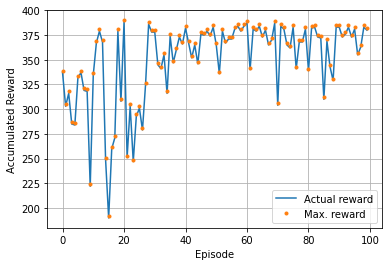

In [56]:
plt.plot(episode_reward, label='Actual reward')
plt.plot(max_reward, '.', label='Max. reward')
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')
plt.grid()
plt.legend()
plt.show()

In [57]:
print(len(rewards))

10000


In [58]:
# RESULTADO SEM USAR O LIST SLICING
rewards0 = np.array(rewards)
print("mean value: ", np.mean(rewards0), " std:", np.std(rewards0), " min:", min(rewards0), " max:", max(rewards0))

mean value:  327.3688  std: 43.49333266789291  min: 58.0  max: 396.0


In [59]:
# RESULTADO USANDO O LIST SLICING para pegar os N últimos elementos da lista
# initializing N
N = 365 #
 
# using list slicing
# Get last N elements from list
res = rewards[-N:]

In [60]:

rewards_test = np.array(res)
print("mean value: ", np.mean(rewards_test), " std:", np.std(rewards_test), " min:", min(rewards_test), " max:", max(rewards_test))

mean value:  335.64383561643837  std: 46.897956804229054  min: 138.0  max: 388.0


In [61]:
max_reward

array([339., 305., 318., 287., 286., 334., 339., 321., 320., 224., 337.,
       369., 381., 370., 251., 192., 262., 273., 381., 310., 390., 253.,
       305., 249., 295., 303., 281., 327., 388., 380., 380., 347., 343.,
       357., 318., 376., 349., 362., 375., 368., 384., 369., 354., 367.,
       348., 378., 377., 381., 376., 385., 367., 338., 381., 369., 373.,
       373., 383., 386., 381., 386., 389., 342., 383., 381., 386., 375.,
       382., 367., 372., 389., 306., 386., 383., 367., 364., 385., 343.,
       370., 370., 383., 341., 384., 385., 375., 374., 312., 371., 345.,
       331., 385., 385., 375., 378., 385., 375., 383., 357., 365., 385.,
       382.])

In [62]:
episode_reward

array([337., 303., 316., 285., 284., 332., 337., 319., 318., 222., 335.,
       367., 379., 368., 249., 190., 260., 271., 379., 308., 388., 251.,
       303., 247., 293., 301., 279., 325., 386., 378., 378., 345., 341.,
       355., 316., 374., 347., 360., 373., 366., 382., 367., 352., 365.,
       346., 376., 375., 379., 374., 383., 365., 336., 379., 367., 371.,
       371., 381., 384., 379., 384., 387., 340., 381., 379., 384., 373.,
       380., 365., 370., 387., 304., 384., 381., 365., 362., 383., 341.,
       368., 368., 381., 339., 382., 383., 373., 372., 310., 369., 343.,
       329., 383., 383., 373., 376., 383., 373., 381., 355., 363., 383.,
       380.])

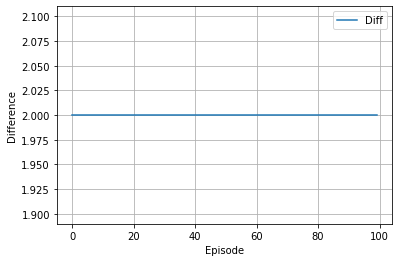

In [63]:
diff  = (max_reward - episode_reward)
plt.plot(diff, label='Diff')
plt.xlabel('Episode')
plt.ylabel('Difference')
plt.grid()
plt.legend()
plt.show()

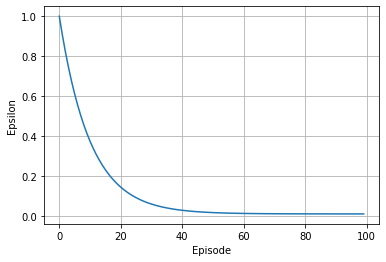

In [64]:
plt.plot(epsilon_vec)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid()
plt.show()

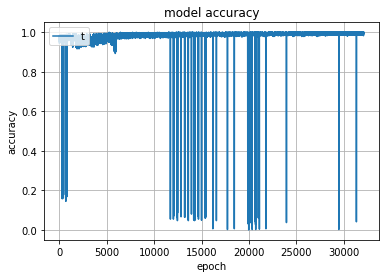

In [65]:
# summarize history for accuracy
plt.plot(acc_history)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.grid()
plt.show()

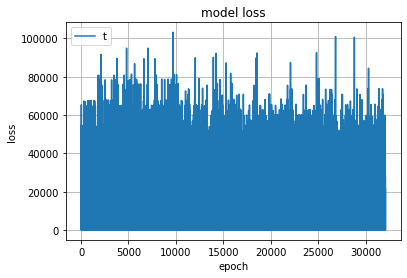

In [66]:
# summarize history for loss
plt.plot(loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.grid()
plt.show()